In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, Sequential
from keras import layers
from keras.optimizers import Adam
from keras.regularizers import L1, L2, Regularizer, L1L2
from keras import ops
from keras.callbacks import ReduceLROnPlateau

import imblearn

from time import perf_counter

## Init

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\thead\AppData\Local\Temp\ipykernel_15212\1297277926.py:2: DtypeWarning: Columns (2155) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [5]:
trait_cols = np.array(['Photo',
       'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo',
       'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C',
       'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a',
       'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch',
       'Ellagic', 'Gal', 'Rut', 'CTs'])

In [6]:
x_spec = df[spec_cols].values
yb = df[stresses].values.any(axis=1)

# del df

### Helper Functions

In [7]:
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

In [8]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

## Preprocessing

In [9]:
x_spec = ((x_spec - x_spec.min(axis=0))/(x_spec.max(axis=0)-x_spec.min(axis=0)))

In [10]:
x_spec_train, x_spec_val, yb_train, yb_val = train_test_split(x_spec, yb, test_size=.2)

## Custom Stuff

In [185]:
def ResBlock1D(x):
    # padding has to be 'same' for add to work
    
    fx = layers.Conv1D(10, 3, activation='relu', padding='same', kernel_regularizer=L2(.002))(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv1D(10, 3, activation='relu', padding='same', kernel_regularizer=L2(.002))(fx)

    cx = layers.Conv1D(10, 1, activation='relu', padding='same', kernel_regularizer=L2(.002))(x)
    out = layers.Add()([cx, fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    out = layers.MaxPooling1D(5)(out)
    return out

In [186]:
def InceptionBlock(x):
    fx0 = layers.Conv1D(1, 1, activation='relu', padding='same', kernel_regularizer=L2(.002))(x)

    fx1 = layers.Conv1D(1, 1, activation='relu', padding='same', kernel_regularizer=L2(.002))(x)
    fx1 = layers.Conv1D(10, 3, activation='relu', padding='same', kernel_regularizer=L2(.002))(fx1)

    fx2 = layers.Conv1D(1, 1, activation='relu', padding='same', kernel_regularizer=L2(.002))(x)
    fx2 = layers.Conv1D(10, 5, activation='relu', padding='same', kernel_regularizer=L2(.002))(fx2)
    
    fx3 = layers.MaxPooling1D(4)(x)
    fx3 = layers.Conv1D(1, 1, activation='relu', padding='same', kernel_regularizer=L2(.002))(fx3)
    fx3 = layers.UpSampling1D(4)(fx3)
    fx3 = layers.ZeroPadding1D((0,fx1.shape[1]-fx3.shape[1]))(fx3)

    # fx4 = layers.Conv1D(1, 1, activation='relu', padding='same', kernel_regularizer=L2(.001))(x)
    # fx4 = layers.Conv1D(10, 20, activation='relu', padding='same', kernel_regularizer=L2(.001))(fx4)

    out = layers.Concatenate()([fx0, fx1, fx2, fx3])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)

    return out

###

In [51]:
aug_sel = np.random.randint(x_spec_train.shape[0], size=1000)
x_spec_train_aug = x_spec_train[aug_sel]
yb_train_aug = yb_train[aug_sel]

#### Magnify

In [52]:
x_spec_train_aug += (np.random.random(size=x_spec_train_aug.shape[0])*.0 + 1).reshape((-1,1))

In [53]:
x_spec_train_aug += np.random.normal(scale=.01, size=x_spec_train_aug.shape)

#### Noise

## CNN

In [187]:
fuzzy_win = 5
blur_factor = 1

spatial_dropout_k = 0.1
dropout_k = .2

cnn_model_layers = [
    layers.GaussianNoise(0.00),
    layers.Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    layers.AveragePooling1D(blur_factor),
    ResBlock1D,
    InceptionBlock,
    layers.AveragePooling1D(2),
    InceptionBlock,
    ResBlock1D,
    layers.AveragePooling1D(4),
    layers.SpatialDropout1D(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=L2(.002)),
    layers.Dropout(dropout_k),
    layers.Dense(128, activation='relu', kernel_regularizer=L2(.002)),
    layers.Dropout(dropout_k),
    layers.Dense(128, activation='relu', kernel_regularizer=L2(.002)),
    layers.Dropout(dropout_k),
    layers.Dense(1, activation='sigmoid')
]

cnn_model_inputs = layers.Input(shape=(x_spec_train.shape[1],1))

fx = cnn_model_inputs
for layer in cnn_model_layers:
    fx = layer(fx)
    print(fx)

cnn_model_outputs = fx
cnn_model = Model(inputs=cnn_model_inputs, outputs=cnn_model_outputs)

cnn_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

<KerasTensor shape=(None, 2151, 1), dtype=float32, sparse=False, name=keras_tensor_3252>
<KerasTensor shape=(None, 2142, 1), dtype=float32, sparse=False, name=keras_tensor_3253>
<KerasTensor shape=(None, 2142, 1), dtype=float32, sparse=False, name=keras_tensor_3254>
<KerasTensor shape=(None, 428, 10), dtype=float32, sparse=False, name=keras_tensor_3262>
<KerasTensor shape=(None, 428, 22), dtype=float32, sparse=False, name=keras_tensor_3274>
<KerasTensor shape=(None, 214, 22), dtype=float32, sparse=False, name=keras_tensor_3275>
<KerasTensor shape=(None, 214, 22), dtype=float32, sparse=False, name=keras_tensor_3287>
<KerasTensor shape=(None, 42, 10), dtype=float32, sparse=False, name=keras_tensor_3295>
<KerasTensor shape=(None, 10, 10), dtype=float32, sparse=False, name=keras_tensor_3296>
<KerasTensor shape=(None, 10, 10), dtype=float32, sparse=False, name=keras_tensor_3297>
<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor_3298>
<KerasTensor shape=(None, 12

In [188]:
start = perf_counter()

history = cnn_model.fit(
    cnn_reshape(x_spec_train),
    yb_train,
    epochs=300,
    validation_data=(cnn_reshape(x_spec_val), yb_val),
    batch_size=5,
    # callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=20, min_lr=1e-5)]
)

print(perf_counter() - start)

Epoch 1/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5689 - loss: 1.6162 - val_accuracy: 0.6812 - val_loss: 1.5317
Epoch 2/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6100 - loss: 1.5480 - val_accuracy: 0.6812 - val_loss: 1.5137
Epoch 3/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6119 - loss: 1.4982 - val_accuracy: 0.6812 - val_loss: 1.4738
Epoch 4/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6509 - loss: 1.4535 - val_accuracy: 0.6812 - val_loss: 1.4380
Epoch 5/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6251 - loss: 1.4537 - val_accuracy: 0.6812 - val_loss: 1.3979
Epoch 6/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6155 - loss: 1.4488 - val_accuracy: 0.6812 - val_loss: 1.3718
Epoch 7/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6420 - loss: 1.4015 - val_accuracy: 0.6812 - val_loss: 1.3537
Epoch 8/300
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6600 - loss: 1.3693 - 

In [189]:
((cnn_model.predict(cnn_reshape(x_spec_val)) > .5) == yb_val).mean()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


0.5568858083035777

In [90]:
(yb_val).mean()

0.6811594202898551

Text(0.5, 1.0, 'CNN Loss over Training')

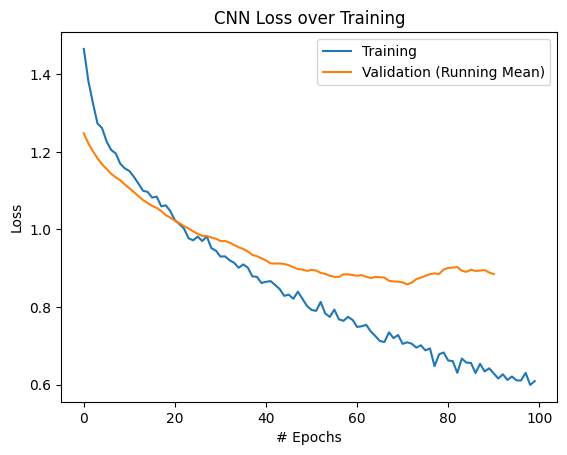

In [91]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
# ax.set_ylim((0, 5))
ax.set_title('CNN Loss over Training')

Text(0.5, 1.0, 'CNN Accuracy over Training')

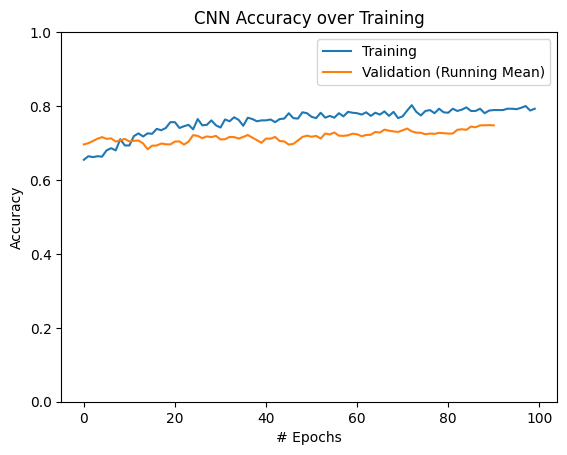

In [166]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('CNN Accuracy over Training')